In [1]:
# モジュールをインポート
import numpy as np
from numpy import random as rd
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.fftpack import fft
from scipy.fftpack import fftfreq
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
# 各惑星系におけるパラメータ及び必要な測光制度
fname = '/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Simulation/Secondary/Revise'
z = np.load('{}/Data/parameter_3000.npy'.format(fname))
T_star = np.load('{}/Data/temperature.npy'.format(fname)).astype(int)
R_star = np.load('{}/Data/radius.npy'.format(fname))*6.960*10**10
R_planet = R_planet = 6.378137*10**8
P = np.load('{}/Data/period.npy'.format(fname))
a = np.load('{}/Data/semi.npy'.format(fname))
p = R_planet/R_star
t_exp = 60
P_tra = P*R_star/np.pi/a
t_one = (P_tra*3/t_exp).astype(np.int64)

# データの取得

In [3]:
# 波長のリストを取得し、10µmの位置番号を取得
lamb = np.load('{}/Data/lamb.npy'.format(fname))
lamb_10 = np.abs(lamb-10)
l_10 = np.where(lamb_10==lamb_10.min())[0][0]

In [4]:
# スペクトルデータと各評価値を取得
df_spectrum = pd.ExcelFile('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Data/planet_spectrum.xlsx').parse('secondary')

volume_num = 1
n = 100
T_len = 4
lamb_len = len(lamb)
sci_eva = np.array([np.load('{}/Result/sci_evaluation_secondary_{}.npy'.format(fname, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sci_sig = np.array([np.load('{}/Result/sci_sigma_secondary_{}.npy'.format(fname, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
wog_eva = np.array([np.load('{}/Result/wog_evaluation_secondary_{}.npy'.format(fname, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
wog_sig = np.array([np.load('{}/Result/wog_sigma_secondary_{}.npy'.format(fname, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_both_eva = np.array([np.load('{}/Result/sub_evaluation_both_secondary_{}.npy'.format(fname, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_both_sig = np.array([np.load('{}/Result/sub_sigma_both_secondary_{}.npy'.format(fname, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_back_eva = np.array([np.load('{}/Result/sub_evaluation_back_secondary_{}.npy'.format(fname, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_back_sig = np.array([np.load('{}/Result/sub_sigma_back_secondary_{}.npy'.format(fname, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_ref_eva = np.array([np.load('{}/Result/sub_evaluation_ref_secondary_{}.npy'.format(fname, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_ref_sig = np.array([np.load('{}/Result/sub_sigma_ref_secondary_{}.npy'.format(fname, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)

# データの修正

In [5]:
# 系統誤差とランダム誤差をそれぞれの平均値と分散値でガウス分布する値を作成
def Gauss(eva, sig, num):
    eva_mean = np.mean(eva, axis=0)
    eva_std = np.std(eva, axis=0)
    systematic = rd.normal(eva_mean, eva_std)
    sig_mean = np.mean(sig, axis=0)
    sig_std = np.std(sig, axis=0)
    random = rd.normal(sig_mean, sig_std)
    return systematic, random

sci_sys, sci_rand = Gauss(sci_eva, sci_sig, len(sci_eva))
wog_sys, wog_rand = Gauss(wog_eva, wog_sig, len(wog_eva))
sub_both_sys, sub_both_rand = Gauss(sub_both_eva, sub_both_sig, len(sub_both_eva))
sub_back_sys, sub_back_rand = Gauss(sub_back_eva, sub_back_sig, len(sub_back_eva))
sub_ref_sys, sub_ref_rand = Gauss(sub_ref_eva, sub_ref_sig, len(sub_ref_eva))

In [6]:
# 各評価値の標準偏差を取得
sci_eva_std = np.std(sci_eva, axis=0)
wog_eva_std = np.std(wog_eva, axis=0)
sub_both_eva_std = np.std(sub_both_eva, axis=0)
sub_back_eva_std = np.std(sub_back_eva, axis=0)
sub_ref_eva_std = np.std(sub_ref_eva, axis=0)

In [7]:
# R=100におけるspectrumを作成
lamb_raw = df_spectrum.wavelength.values
spectrum_raw = np.array([df_spectrum[temp].values for temp in ['2500K', '3000K', '3500K', '4000K']])*10**6
func = [interpolate.interp1d(lamb_raw, spectrum_raw[T], kind='cubic') for T in range(4)]
spectrum = [func[T](lamb) for T in range(4)]

# グラフ化

In [8]:
# 系統誤差とランダム誤差を示す図を作成
def Evaluation(i, T, ylim_min, ylim_max, text=True, text_pos=False):
    std_markersize = 2
    rand_markersize = 4
    ax = fig.add_subplot(i)
    #ax.plot(lamb, abs(wog_eva_std[T]), 'ro', c='g', markersize=std_markersize)
    ax.plot(lamb, abs(sci_eva_std[T]), 'ro', c='r', markersize=std_markersize)
    ax.plot(lamb, abs(sub_both_eva_std[T]), 'ro', c='c', markersize=std_markersize)
    ax.plot(lamb, abs(sub_back_eva_std[T]), 'ro', c='g', markersize=std_markersize)
    ax.plot(lamb, abs(sub_ref_eva_std[T]), 'ro', c='b', markersize=std_markersize)
    ax.plot(lamb, abs(wog_rand[T]), 'x', c='r', markersize=rand_markersize)
    #ax.plot(lamb, abs(sci_rand[T]), 'x', c='r', markersize=rand_markersize)
    ax.plot(lamb, abs(sub_both_rand[T]), 'x', c='c', markersize=rand_markersize)
    ax.plot(lamb, abs(sub_back_rand[T]), 'x', c='g', markersize=rand_markersize)
    ax.plot(lamb, abs(sub_ref_rand[T]), 'x', c='b', markersize=rand_markersize)
    ax.set_xlabel('Wavelength [μm]')
    ax.set_ylabel('ppm')
    ax.set_xlim(lamb[0], lamb[-1])
    ax.set_ylim(ylim_min, ylim_max)
    if text:
        if text_pos:
            ax.annotate('{}K'.format(T_star[T]), xy=(0.03, 0.7), xycoords='axes fraction', fontsize=28, ha='left', va='bottom')
        else:
            ax.annotate('{}K'.format(T_star[T]), xy=(0.03, 0.85), xycoords='axes fraction', fontsize=28, ha='left', va='bottom')

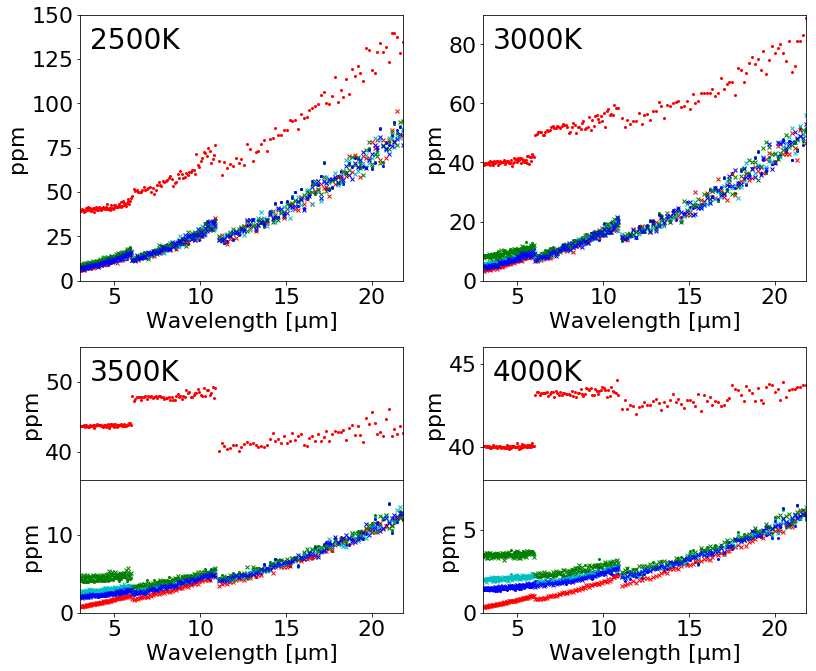

In [9]:
# R=100
fig = plt.figure(figsize=(13, 11))
plt.rcParams['font.size']=22
gs = gridspec.GridSpec(9, 2)
Evaluation(gs[0:4, 0], 0, 0, 150)
Evaluation(gs[0:4, 1], 1, 0, 90)
Evaluation(gs[5:7, 0], 2, 36, 55, text_pos=True)
plt.xticks([])
Evaluation(gs[7:9, 0], 2, 0, 17, text=False)
Evaluation(gs[5:7, 1], 3, 38, 46, text_pos=True)
plt.xticks([])
Evaluation(gs[7:9, 1], 3, 0, 8, text=False)
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/systematic_evaluation_secondary.pdf')
plt.show()

In [69]:
# 地球大気の吸収スペクトルに補正後のデータを載せた図を作成
def Spectrum(i, T, sub='both', x_min=3, x_max=22, y_min=None, y_max=None):
    if sub=='both':
        sub_eva = sub_both_eva[:, T]
        sub_sig = sub_both_sig[:, T]
    elif sub=='back':
        sub_eva = sub_back_eva[:, T]
        sub_sig = sub_back_sig[:, T]
    else:
        sub_eva = sub_ref_eva[:, T]
        sub_sig = sub_ref_sig[:, T]
    x = lamb
    y = spectrum[T]
    y_sys = sub_eva[rd.choice(np.arange(100))]
    y_err = sub_sig[rd.choice(np.arange(100))]
    sys_error = y+y_sys
    ax = fig.add_subplot(i)
    ax.plot(x, y, c='r', linewidth=2.0)
    ax.plot(x, sys_error, 'ro', c='g', markersize=4.0)
    ax.errorbar(x, sys_error, yerr=y_err, fmt='ro', markersize=0.0, ecolor='k')
    ax.set_xlabel('Wavelength [μm]')
    ax.set_ylabel('Transit depth [ppm]')
    ax.set_xlim(x_min, x_max)
    ax.annotate('$\it{O_{3}}$', color='c', xy=(9.7, O3_arrow[T]), xytext=(8.8, O3[T]),
                arrowprops=dict(arrowstyle='wedge', facecolor='c', edgecolor='c'))
    ax.annotate('$\it{CO_{2}}$', color='c', xy=(15, CO2_arrow[T]), xytext=(13.8, CO2[T]),
                arrowprops=dict(arrowstyle='wedge', facecolor='c', edgecolor='c'))
    ax.annotate('{}K'.format(T_star[T]), xy=(0.03, 0.85), xycoords='axes fraction', fontsize=28, ha='left', va='bottom')

15


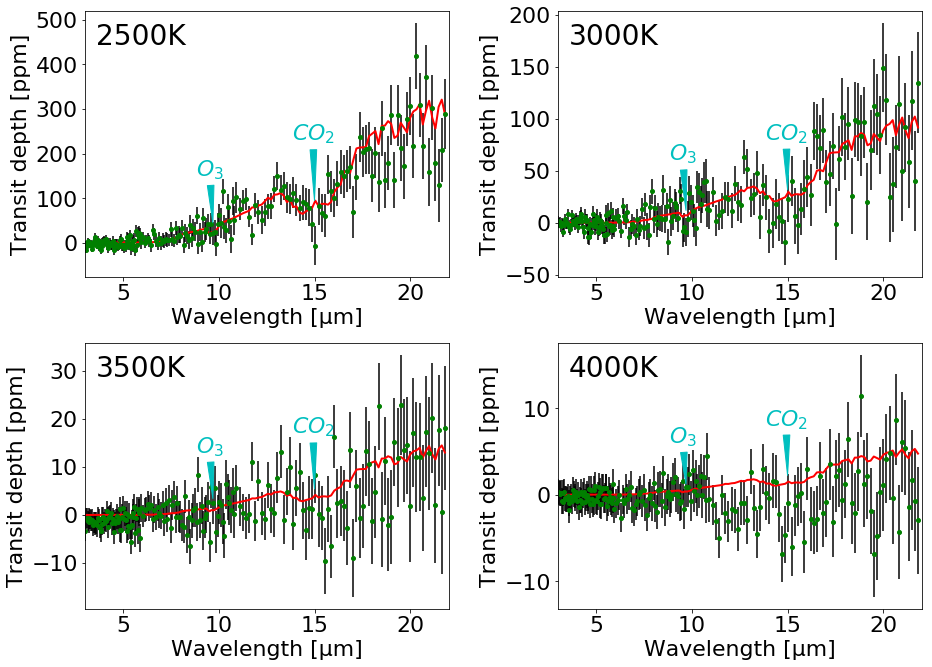

In [82]:
# R=100
random = rd.randint(100)
print(random)
sub = 'ref'
O3 = [150, 60, 13, 6]
O3_arrow = [40, 10, 3, 1]
CO2 = [230, 80, 17, 8]
CO2_arrow = [90, 30, 5, 2]
fig = plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 22
rd.seed(24)
Spectrum(221, 0, sub=sub)
rd.seed(5)
Spectrum(222, 1, sub=sub)
rd.seed(3)
Spectrum(223, 2, sub=sub)
rd.seed(54)
Spectrum(224, 3, sub=sub)
plt.subplots_adjust(hspace=0.25, wspace=0.3)
#plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/spectrum_secondary.pdf')
plt.show()